In [38]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Retrain or use existing models
use_cached_weights = True

# Control figure size
figsize=(14, 3.5)
figsize_narrow=(14, 2.5)

from util import util
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')


# Generate a problem instance
nitems, rel_req, seed = 20, 0.5, 42
prb = util.generate_problem(nitems=nitems, rel_req=rel_req, seed=seed)

# Generate basic dataset
data_tr = util.generate_costs(nsamples=350, nitems=nitems, seed=seed, noise_scale=0, noise_type='normal', noise_scale_type='absolute')
data_ts = util.generate_costs(nsamples=150, nitems=nitems, seed=seed, sampling_seed=seed+1, noise_scale=0, noise_type='normal', noise_scale_type='absolute')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Applicability of DFL

## Let's Second-Guess Ourselvers

**However, let's not discount the prediction-focused approach yet**

In fact, it's easy to see that:

$$
\mathbb{E}[\text{regret}(y, \hat{y})] \xrightarrow[\mathbb{E}\lbrack L(y, \hat{y}) \rbrack \to 0]{} 0
$$

Intuitively:

* The more accurate we can be, the lower the regret
* Eventually, perfect predictions will result in 0 regret

**But then... What if we make our model bigger?**

* We could get good predictions _and_ good regret
* ...And training would be _much_ faster

## Our Baseline

**Let's check again the results for our PFL linear regressor**

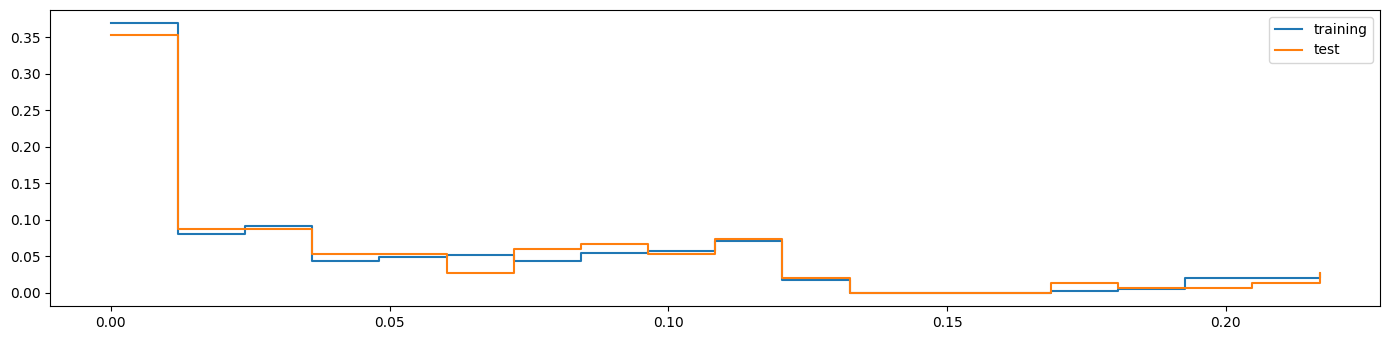

Mean: 0.052 (training), 0.052 (test)


In [39]:
pfl = util.build_ml_model(input_size=1, output_size=nitems, hidden=[], name='pfl_det', output_activation='linear')
history = util.train_ml_model(pfl, data_tr.index.values, data_tr.values, epochs=1000, loss='mse', validation_split=0, save_weights=False, load_weights=True)
r_tr = util.compute_regret(prb, pfl, data_tr.index.values, data_tr.values)
r_ts = util.compute_regret(prb, pfl, data_ts.index.values, data_ts.values)
util.plot_histogram(r_tr, figsize=figsize, label='training', data2=r_ts, label2='test', print_mean=True);

This will be our main baseline

## PFL Strikes Back

**Let's try to use _a non-linear model_**

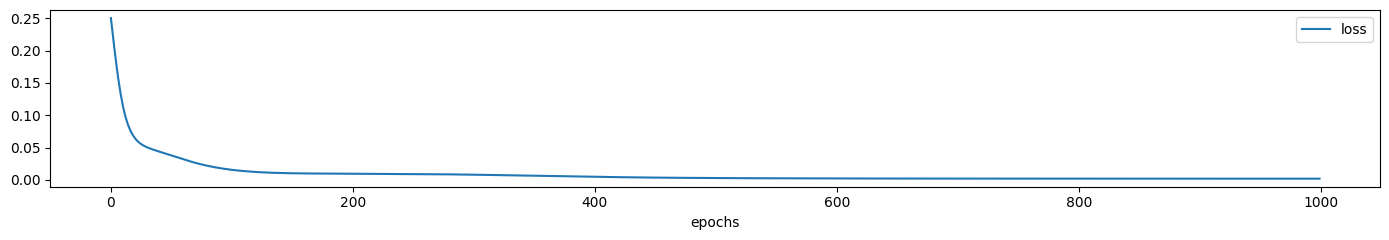

Training time: 12.5487 sec
R2: 0.98, MAE: 0.03, RMSE: 0.04 (training)
R2: 0.98, MAE: 0.03, RMSE: 0.04 (test)


In [40]:
pfl_acc = util.build_ml_model(input_size=1, output_size=nitems, hidden=[8], name='pfl_det_acc', output_activation='linear')
history = util.train_ml_model(pfl_acc, data_tr.index.values, data_tr.values, epochs=1000, loss='mse', validation_split=0, save_weights=True, load_weights=use_cached_weights)
util.plot_training_history(history, figsize=figsize_narrow, print_scores=False, print_time=True)
util.print_ml_metrics(pfl_acc, data_tr.index.values, data_tr.values, label='training')
util.print_ml_metrics(pfl_acc, data_ts.index.values, data_ts.values, label='test')

More accurate, it is!

## PFL Strikes Back

**...And the improvement in terms of regret is remarkable**

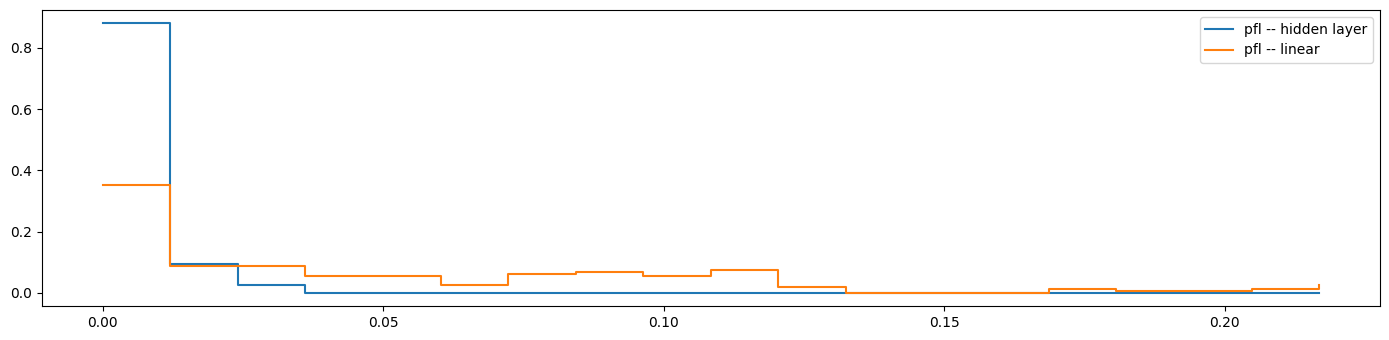

Mean: 0.004 (pfl -- hidden layer), 0.052 (pfl -- linear)


In [41]:
r_ts_acc = util.compute_regret(prb, pfl_acc, data_ts.index.values, data_ts.values)
util.plot_histogram(r_ts_acc, figsize=figsize, label='pfl -- hidden layer', data2=r_ts, label2='pfl -- linear', print_mean=True);

## PFL Strikes Back

**Let's what DFL could do with the same model coplexity**

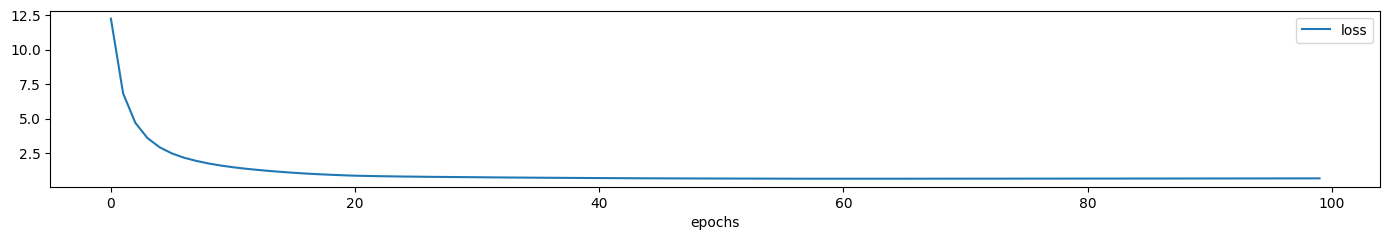

Training time: 52.3219 sec
R2: -0.29, MAE: 0.23, RMSE: 0.28 (training)
R2: -0.29, MAE: 0.23, RMSE: 0.28 (test)


In [44]:
spo_nonlinear = util.build_dfl_ml_model(input_size=1, output_size=nitems, problem=prb, hidden=[8], name='spo_nonlinear', output_activation='linear', loss_type='spo', recompute_chance=1)
history = util.train_dfl_model(spo_nonlinear, data_tr.index.values, data_tr.values, epochs=100, verbose=0, validation_split=0, save_weights=True, load_weights=use_cached_weights, warm_start_pfl=None)
util.plot_training_history(history, figsize=figsize_narrow, print_scores=False, print_time=True)
util.print_ml_metrics(spo_nonlinear, data_tr.index.values, data_tr.values, label='training')
util.print_ml_metrics(spo_nonlinear, data_ts.index.values, data_ts.values, label='test')

## PFL Strikes Back

**The gap between the approach is basically closed**

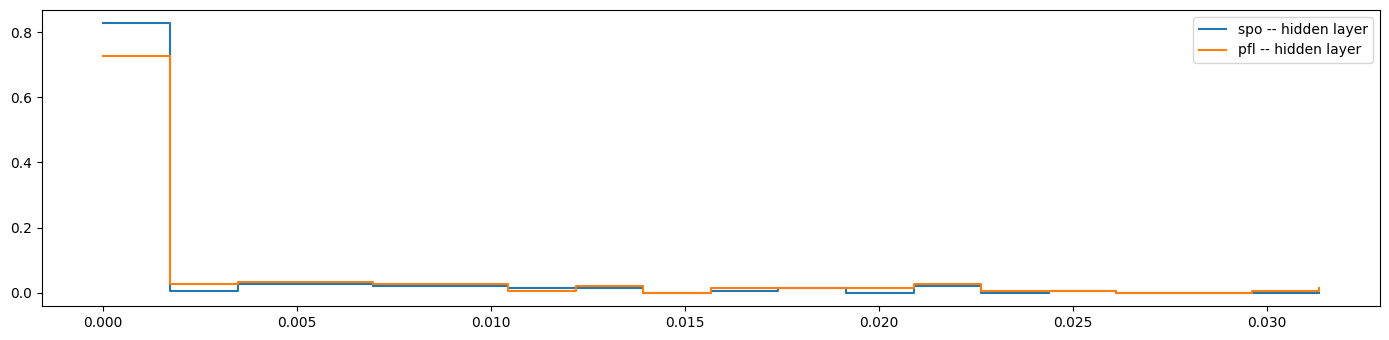

Mean: 0.002 (spo -- hidden layer), 0.004 (pfl -- hidden layer)


In [45]:
r_ts_spo_nonlinear = util.compute_regret(prb, spo_nonlinear, data_ts.index.values, data_ts.values)
fig = util.plot_histogram(r_ts_spo_nonlinear, figsize=figsize, label='spo -- hidden layer', data2=r_ts_acc, label2='pfl -- hidden layer', print_mean=True)
fig.savefig('pfl_dfl_shallow.pdf')

## Evening the Field

**Can't we do anything about it?**

* DFL predictions will always be off (more or less)
* ...But there are ways to make the approach faster

**For example:**

* You can use a relaxation, e.g. the [LP relaxation of a MILP](https://proceedings.neurips.cc/paper/2020/file/51311013e51adebc3c34d2cc591fefee-Paper.pdf)
* You can limit recomputation by [caching past solutions](https://arxiv.org/pdf/2011.05354)
* You can warm start the DFL approach with the PFL weights

Let's see the last two tricks in deeper detail

## Warm Starting and Solution Caching

**Warm starting simple consists in using the PFL weights to _initialize $\theta$_**

Since accuracy is correlated with regret, this might accelerate convergence

**Solution caching is applicable if _the feasible space is fixed_**

I.e. to problems in the form:

$$
z^*(y) = \text{argmin}_{z} \{f(z) \mid \color{red}{z \in F}\}
$$

* During training, we maintain a solution cache $S$
* Initially, we populate $S$ with the true optimal solutions $z^*(y_i)$ for all examples
* Before computing $z^*(\hat{y})$ for the current prediction we flip a coin
* With probability $p$, we run the computation (and store any new solution in $S$)
* With probability $1 - p$, we solve instead $\hat{z}^*(\hat{y}) = \text{argmin}_{z} \{f(z) \mid z \in S\}$

## Speeding Up DFL

**Let's use DFL _with linear regression_, a warm start, and a solution cache**

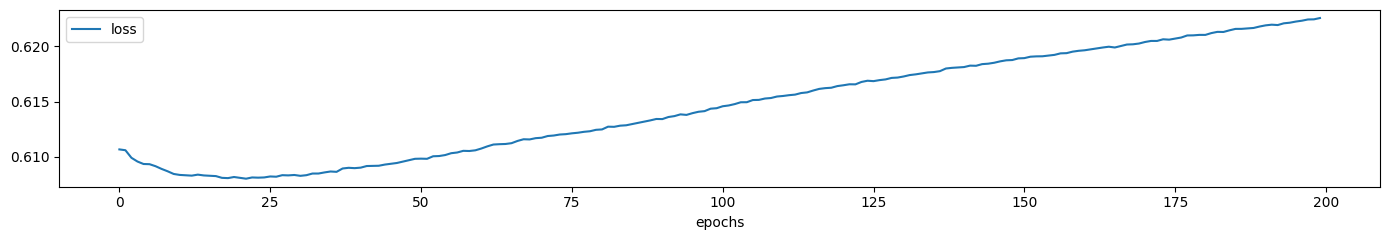

Training time: 22.7765 sec
R2: 0.64, MAE: 0.12, RMSE: 0.16 (training)
R2: 0.64, MAE: 0.12, RMSE: 0.16 (test)


In [46]:
spo = util.build_dfl_ml_model(input_size=1, output_size=nitems, problem=prb, hidden=[], name='spo_boosted', output_activation='linear', loss_type='spo', recompute_chance=0.05)
history = util.train_dfl_model(spo, data_tr.index.values, data_tr.values, epochs=200, verbose=0, validation_split=0, save_weights=True, load_weights=use_cached_weights, warm_start_pfl=pfl)
util.plot_training_history(history, figsize=figsize_narrow, print_scores=False, print_time=True)
util.print_ml_metrics(spo, data_tr.index.values, data_tr.values, label='training')
util.print_ml_metrics(spo, data_ts.index.values, data_ts.values, label='test')

The training time is still large, but much lower than our earlier DFL attempt

## Speeding Up DFL

**And the regret is even better than before!**

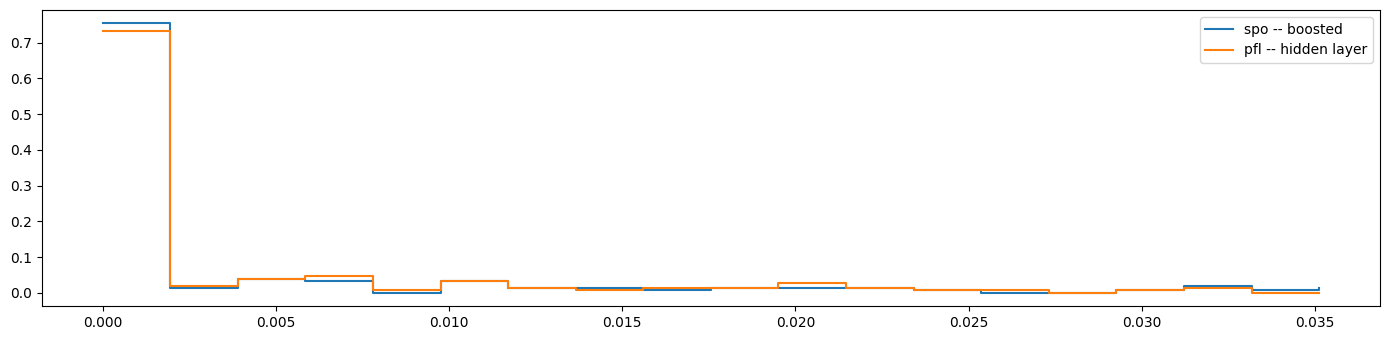

Mean: 0.004 (spo -- boosted), 0.004 (pfl -- hidden layer)


In [49]:
r_ts_spo = util.compute_regret(prb, spo, data_ts.index.values, data_ts.values)
util.plot_histogram(r_ts_spo, figsize=figsize, label='spo -- boosted', data2=r_ts_acc, label2='pfl -- hidden layer', print_mean=True);

* We are matching the more complex PFL model with a simple linear regressor
* ...And the training time is much better than before

## Reflecting on What we Have

**Therefore, DFL gives us at least _two benefits_**

First, it can lead to _lower regret_ compared to a prediction-focused appraoch

* As the models become more complex we have diminishing returns
* ...But for some applications every little bit counts

Second, it may allow using _simpler ML models_

* Simple models are faster to evaluate
* ...But more importantly they are _easier to explain_
* E.g. we can easily perform feature importance analysis

> **Intuitively, DFL works best _where PFL has estimation issues_**<br>
> Can we exploit this fact to maximize our advantage?